In [3]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv

In [4]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_random_slow_00"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

_webcam_cam_mat

array([[671.25534529,   0.        , 678.00736213],
       [  0.        , 692.23316717, 443.37269229],
       [  0.        ,   0.        ,   1.        ]])

In [14]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.05
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [15]:
video_folders_pth = os.path.join(_base_pth)
video_folders_list = os.listdir(video_folders_pth)
video_folders_list = video_folders_list[4:]
_text_pth = os.path.join(_webcam_calib_folder, "..", "00_analysis", "folder_names.txt")

In [16]:
"""write folder names to text file"""
with open(_text_pth, "w") as f:
    for i in video_folders_list:
        f.write(i + "\n")

In [17]:
with open(_text_pth, "r") as f:
    video_folders_list = f.readlines()
    video_folders_list = [i.strip() for i in video_folders_list]

In [18]:
video_folders_list

['sk40_30_4_random1',
 'sk40_30_4_random2',
 'sk40_30_4_random3',
 'sk40_30_4_random5',
 'sk40_30_4_random7',
 'sk40_30_4_random_mocap_0',
 'sk40_30_4_random_mocap_1',
 'sk40_30_4_random_mocap_2',
 'sk40_30_4_random_slow_00',
 'sk40_30_5_random0',
 'sk40_30_5_random6',
 'sk40_40_4_random4']

In [9]:

default_ids = [0, 49, 80]
data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _folder_name in video_folders_list:
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

    for _frame in tqdm(_video_data):

        shape = _frame.shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

        corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = board,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = _webcam_cam_mat,
            distCoeffs = _webcam_dist)

        rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

        if ids is None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(None)
            data["corners"].append(None)
            data["tvec"].append(None)
            data["rvec"].append(None)

        if ids is not None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(ids)
            data["corners"].append(corners)
            data["tvec"].append(translation_vectors)
            data["rvec"].append(rotation_vectors)

        counter+=1

    _video_file.close()

140it [00:02, 57.45it/s]
296it [00:05, 51.94it/s]
1044it [00:19, 54.12it/s]
848it [00:14, 60.39it/s] 
1189it [00:16, 72.95it/s]
948it [00:16, 58.57it/s]
1160it [00:18, 62.24it/s]
533it [00:08, 62.88it/s]
613it [00:08, 72.76it/s]
934it [00:14, 66.55it/s]
892it [00:13, 64.22it/s]
403it [00:05, 69.22it/s]
764it [00:10, 73.73it/s]
1784it [00:23, 76.13it/s] 


In [10]:
coordinate = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

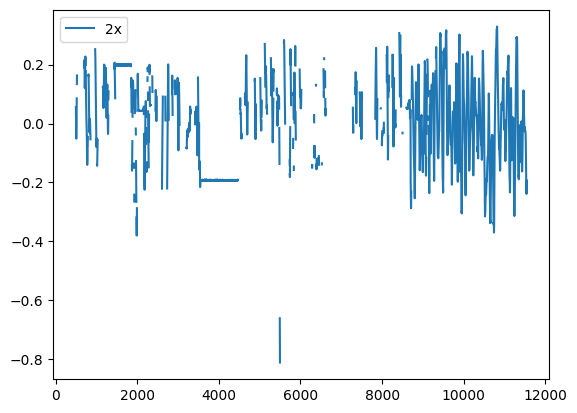

In [11]:
# plt.plot(coordinate["0"]["x"], label="x")
# plt.plot(coordinate["49"]["x"], label="1x")
plt.plot(coordinate["80"]["x"], label="2x")
plt.legend()

In [24]:
raw_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_data_pth = os.path.join(raw_data_pth, 'dataset',"multi_class", "raw_data")
if not os.path.exists(raw_data_pth):
    os.makedirs(os.path.join(raw_data_pth, "images"))
    os.makedirs(os.path.join(raw_data_pth, "labels"))
    

# based on the coordinate, we can create the labels
# we will create the labels for each frame


counter = 0
default_ids = [0, 49, 80]
file_remove = False


for _folder_name in video_folders_list:

    doesnt_exist = [] # list of ids that doesnt exist in a frame
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

    _current_xvec_0 = 0.
    _current_yvec_0 = 0.
    _current_zvec_0 = 0.

    _previous_xvec_0 = 0.
    _previous_yvec_0 = 0.
    _previous_zvec_0 = 0.
    
    _current_xvec_49 = 0.
    _current_yvec_49 = 0.
    _current_zvec_49 = 0.

    _previous_xvec_49 = 0.
    _previous_yvec_49 = 0.
    _previous_zvec_49 = 0.
    
    _current_xvec_80 = 0.
    _current_yvec_80 = 0.
    _current_zvec_80 = 0.

    _previous_xvec_80 = 0.
    _previous_yvec_80 = 0.
    _previous_zvec_80 = 0.

    _start_frame_counter = 0

    for _frame in tqdm(_video_data):

        shape = _frame.shape
        height, width, _ = shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        markerCorners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

        markerCorners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = gray,
            board = board,
            detectedCorners = markerCorners,
            detectedIds = ids,
            rejectedCorners = rejectedImgPoints,
            cameraMatrix = _webcam_cam_mat,
            distCoeffs = _webcam_dist)
        
        rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(markerCorners, 0.04, _webcam_cam_mat, _webcam_dist)

        if len(markerCorners) == 0:
            counter += 1
            continue


        img_name = f"image_{counter}.png"

        label_name = img_name.split(".")[0]
        label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")

        _class_name = "0"

        if default_ids[0] not in ids:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in ids:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in ids:
            doesnt_exist.append(default_ids[2])

        for i in range(len(ids)):

            if ids[i][0] == 0:
                if _start_frame_counter == 0:

                    _previous_xvec_0 = translation_vectors[i][0][0]
                    _previous_yvec_0 = translation_vectors[i][0][1]
                    _previous_zvec_0 = translation_vectors[i][0][2]

                _current_xvec_0 = translation_vectors[i][0][0]
                _current_yvec_0 = translation_vectors[i][0][1]
                _current_zvec_0 = translation_vectors[i][0][2]

                if abs(_current_xvec_0 - _previous_xvec_0)>0.1:
                    file_remove = True
                elif abs(_current_yvec_0 - _previous_yvec_0)>0.1:
                    file_remove = True
                elif abs(_current_zvec_0 - _previous_zvec_0)>0.1:
                    file_remove = True

                _previous_xvec_0 = _current_xvec_0
                _previous_yvec_0 = _current_yvec_0
                _previous_zvec_0 = _current_zvec_0
                
            if ids[i][0] == 1:
                
                if _start_frame_counter == 0:

                    _previous_xvec_49 = translation_vectors[i][0][0]
                    _previous_yvec_49 = translation_vectors[i][0][1]
                    _previous_zvec_49 = translation_vectors[i][0][2]

                _current_xvec_49 = translation_vectors[i][0][0]
                _current_yvec_49 = translation_vectors[i][0][1]
                _current_zvec_49 = translation_vectors[i][0][2]

                if abs(_current_xvec_49 - _previous_xvec_49)>0.1:
                    file_remove = True
                elif abs(_current_yvec_49 - _previous_yvec_49)>0.1:
                    file_remove = True
                elif abs(_current_zvec_49 - _previous_zvec_49)>0.1:
                    file_remove = True

                _previous_xvec_49 = _current_xvec_49
                _previous_yvec_49 = _current_yvec_49
                _previous_zvec_49 = _current_zvec_49
                
            if ids[i][0] == 2:
                
                if _start_frame_counter == 0:

                    _previous_xvec_80 = translation_vectors[i][0][0]
                    _previous_yvec_80 = translation_vectors[i][0][1]
                    _previous_zvec_80 = translation_vectors[i][0][2]

                _current_xvec_80 = translation_vectors[i][0][0]
                _current_yvec_80 = translation_vectors[i][0][1]
                _current_zvec_80 = translation_vectors[i][0][2]

                if abs(_current_xvec_80 - _previous_xvec_80)>0.1:
                    file_remove = True
                elif abs(_current_yvec_80 - _previous_yvec_80)>0.1:
                    file_remove = True
                elif abs(_current_zvec_80 - _previous_zvec_80)>0.1:
                    file_remove = True

                _previous_xvec_80 = _current_xvec_80
                _previous_yvec_80 = _current_yvec_80
                _previous_zvec_80 = _current_zvec_80
                

            _markerCorners = markerCorners[i][0]
            bbox_x,bbox_y,bbox_width,bbox_height = cv2.boundingRect(_markerCorners)

            bbox_x = bbox_x / width
            bbox_y = bbox_y / height

            bbox_center_x = bbox_x + bbox_width / (2 * width)
            bbox_center_y = bbox_y + bbox_height / (2 * height)

            bbox_width = bbox_width / width
            bbox_height = bbox_height / height
            if ids[i][0] == 0:
                _class_name = "0"
            elif ids[i][0] == 49:
                _class_name = "1"
            elif ids[i][0] == 80:
                _class_name = "2"

            label_writer.writerow([_class_name, bbox_center_x, bbox_center_y, bbox_width, bbox_height,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])


        label_file.close()
        doesnt_exist = []
        # save image
        image_path = os.path.join(raw_data_pth, "images", img_name)
        cv2.imwrite(image_path, _frame)
        
        if file_remove:
            os.remove(image_path)
            os.remove(label_path)
            file_remove = False
        counter += 1
        _start_frame_counter += 1

    _video_file.close()

1044it [00:26, 38.84it/s]
848it [00:22, 38.21it/s]
1189it [00:31, 37.88it/s]
948it [00:24, 38.19it/s]
1160it [00:28, 40.71it/s] 
533it [00:13, 40.80it/s]
613it [00:12, 50.61it/s]
934it [00:22, 41.52it/s]
892it [00:22, 39.49it/s]
403it [00:10, 40.18it/s]
764it [00:18, 40.66it/s]
1784it [00:51, 34.81it/s]


In [28]:
_raw_saved_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
_raw_saved_data_pth = os.path.join(_raw_saved_data_pth, 'dataset',"multi_class", "raw_data")
_raw_saved_data_pth = os.path.join(_raw_saved_data_pth, "images")
_raw_saved_data_list = os.listdir(_raw_saved_data_pth)

def add_noise(image):
    img = image[...,::-1]/255.0
    noise =  np.random.normal(loc=0, scale=1, size=img.shape)
    img2 = img*2
    n4 = np.clip(np.where(img2 <= 1, (img2*(1 + noise*0.4)), (1-img2+1)*(1 + noise*0.4)*-1 + 2)/2, 0,1)
    return n4

def gaussian_noise(image):

    gauss_noise=np.zeros(image.shape, dtype=np.uint8)
    cv2.randn(gauss_noise, 0, 5)
    gauss_noise=(gauss_noise*0.5).astype(np.uint8)
    gn_img = cv2.add(image,gauss_noise)
    return gn_img

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

#adding noise to twenty percent of the images
for img_name in tqdm(_raw_saved_data_list):
    _image_path = os.path.join(_raw_saved_data_pth, img_name)
    image = cv2.imread(_image_path)
    #adding noise to twenty percent of the images
    if np.random.random() < 0.2:
        image = gaussian_blur(image)
        _image_path = os.path.join(_raw_saved_data_pth, f"blur_{img_name}")
        cv2.imwrite(_image_path, image)

        label_name = img_name.split(".")[0]
        label_path = os.path.join(_raw_saved_data_pth, "..","labels", f"{label_name}.txt")
        label_file = open(label_path, "r")
        label_reader = csv.reader(label_file, delimiter=" ")
        label = list(label_reader)[0]
        label_file.close()

        label_path = os.path.join(os.path.join(_raw_saved_data_pth, "..", "labels"), f"blur_{img_name.split('.')[0]}.txt")
        label_file = open(label_path, "w")
        label_writer = csv.writer(label_file, delimiter=" ")
        label_writer.writerow(label)
        label_file.close()
    
    # if np.random.random() > 0.2 and np.random.random()<0.4:
    #     image = add_noise(image)
    #     image = cv2.cvtColor(cv2.COLOR_RGB2BGR)
    #     image = (image*255).astype(np.uint8)
    #     _image_path = os.path.join(_raw_saved_data_pth, f"noise_{img_name}")
        
    #     cv2.imwrite(_image_path, image)

    #     label_name = img_name.split(".")[0]
    #     label_path = os.path.join(_raw_saved_data_pth, "..","labels", f"{label_name}.txt")
    #     label_file = open(label_path, "r")
    #     label_reader = csv.reader(label_file, delimiter=" ")
    #     label = list(label_reader)[0]
    #     label_file.close()

    #     label_path = os.path.join(os.path.join(_raw_saved_data_pth, "..", "labels"), f"noise_{img_name.split('.')[0]}.txt")
    #     label_file = open(label_path, "w")
    #     label_writer = csv.writer(label_file, delimiter=" ")
    #     label_writer.writerow(label)
    #     label_file.close()

100%|██████████| 10610/10610 [03:12<00:00, 55.09it/s]


In [29]:
# splitting dataset into train and validation and test
data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_pth = os.path.join(data_pth, 'dataset',"multi_class", "dataset_processed")

images_pth = os.path.join(data_pth, "images")
labels_pth = os.path.join(data_pth, "labels")

if not os.path.exists(images_pth):
    os.makedirs(os.path.join(images_pth, "train"))
    os.makedirs(os.path.join(images_pth, "val"))
    os.makedirs(os.path.join(images_pth, "test"))

if not os.path.exists(labels_pth):
    os.makedirs(os.path.join(labels_pth, "train"))
    os.makedirs(os.path.join(labels_pth, "val"))
    os.makedirs(os.path.join(labels_pth, "test"))
    
    
image_list = os.listdir(os.path.join(raw_data_pth, "images"))

# splitting dataset into train and test
for img_name in tqdm(image_list):
    
    _image_path = os.path.join(raw_data_pth, "images", img_name)
    image = cv2.imread(_image_path)
    
    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "r", newline='')
    label_reader = csv.reader(label_file, delimiter=" ")
    label = list(label_reader)

    label_file.close()
    
    # if int(label[0]) == 0:
    if np.random.rand() < 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "train"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "train"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    elif np.random.rand() < 0.9 and np.random.rand() > 0.7:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "val"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "val"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close()
        
    else:
        # save image
        image_path = os.path.join(os.path.join(images_pth, "test"), img_name)
        cv2.imwrite(image_path, image)
        
        label_path = os.path.join(os.path.join(labels_pth, "test"), f"{label_name}.txt")
        label_file = open(label_path, "w", newline='')
        label_writer = csv.writer(label_file, delimiter=" ")
        for l in label:
            label_writer.writerow(l)
        label_file.close() 


  0%|          | 0/12691 [00:00<?, ?it/s]

100%|██████████| 12691/12691 [07:47<00:00, 27.13it/s]
